In [5]:
import numpy as np
from scipy.linalg import svdvals
from matplotlib import pyplot as plt
import time
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
m = 40
n = 100

We first set up the problem
\begin{align*}
    Ax = b
\end{align*}
where we $A$ is a random, standard Gaussian matrix of dimension $m \times n$ (where the actual size of $m,n$ are defined in the cell immediately above), the true $x$ has 10 randomly selected spikes, and $b$ is given by
\begin{align*}
    b = Ax + \gamma y
\end{align*}
where $y$ is a standard Gaussian noise vector.

In [124]:
gamma = 0.05
A = np.random.normal(0,1,(m,n))
x_true = np.zeros(n)
idx_spike = np.random.randint(0,n,10)
x_true[idx_spike] = 1
b = np.dot(A,x_true) + gamma*np.random.normal(0,1,m)

Here we initialize a first "guess" for $x$.

In [125]:
x_init = np.ones(n)

Now we want to find a potential answer to our inverse problem and solve for some $x$. To do this, we first calculate the $\lambda$ hyperparameter used in the regularized linear least squares problem:
\begin{align*}
     \displaystyle \min_{x} \frac{1}{2}||Ax - b||^{2} + \lambda R(Cx).
\end{align*}
Since we are first implementing the lasso method, we know necessarily that $R(Cx) = ||x||_1$.

In [126]:
lam = np.linalg.norm(np.dot(A.T, b),ord=np.inf)/10

## Section 1 - Implementing simple Lasso

First, we are going to implement the Lasso method. Since Lasso necessarily uses the $||\cdot ||_1$ norm, then we define 
\begin{align}
    \mathrm{prox}_{\lambda || \cdot ||_1}(x) = \mathrm{sign}(x)\mathrm{max}(|x|-\lambda,0)
\end{align}
Note, it is necessary that $x \in \mathbb{R}$.

Here we create a maximum function that compares every element in a $\verb+numpy+$ array to a desired number (of type float or int) and returns a vector of like dimension that has taken the maximum value between the desired number and every element in the array.

In [99]:
def max_function(x, num_compare):
    return np.array([i if i >= num_compare else num_compare for i in x], dtype=float)

This function implements formula (1). Note that every operation is completed entry-wise.

In [100]:
def prox_op(x,lambd):
    return np.sign(x)*max_function(np.abs(x)-lambd,0)

In [119]:
cond_A = svdvals(A)[0]
eta = 0.001
k = 0
tol = 0.00001
max_step = 100
assert eta <= 1/(cond_A**2)

We now create a $\verb+lasso+$ function that will perform the desired prox-gradient descent and solve the inverse problem constructed, with the intent of creating an $\verb+x_guess+$ vector that is as close to $\verb+x_true+$ as possible.

In [9]:
def lasso(x, max_step, k, eta, lam, tol):
    start = time.time()
    while (max_step > tol):
        k += 1
        x_old = x
        x = prox_op(x_old - eta*(A.T)@((A@x_old)-b),eta*lam)
        step = abs((x - x_old)/eta)
        max_step = step.max()
    end = time.time()
    return x, start, end, k

Now we are going to run our $\verb+lasso+$ function and see if, at the very least, it includes the nonzero entries inside our $\verb+x_true+$ vector.

In [10]:
x_guess, start, end, iters = lasso(x_init, max_step, k, eta, lam, tol)

In [11]:
x_guess_nonzero = np.nonzero(x_guess)
x_true_nonzero = np.nonzero(x_true)

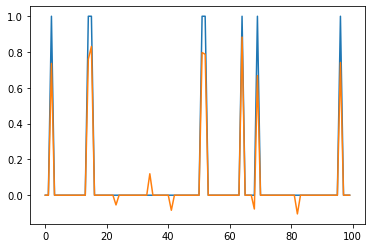

In [12]:
from matplotlib import pyplot as plt
plt.plot(x_true)
plt.plot(x_guess)

In [13]:
np.isin(x_true_nonzero, x_guess_nonzero)

array([[ True,  True,  True,  True,  True,  True,  True,  True]])

From what is directly above, we see clearly that all the nonzero entries inside our true solution $\verb+x_true+$ are at least inside the solution given by the lasso regression, $\verb+x_guess+$. Though, note that the number of nonzero entries in $\verb+x_guess+$ is greater than that of $\verb+x_true+$:

In [14]:
print("This is the number of nonzero entries in x_guess: " + str(len(x_guess_nonzero[0])))
print("This is the number of nonzero entries in x_true: " + str(len(x_true_nonzero[0])))

This is the number of nonzero entries in x_guess: 13
This is the number of nonzero entries in x_true: 8


Hence, there is imprecision in that we would prefer to have more entries in $\verb+x_guess+$ to be closer to 0.

We also show the number of iterations and the time it takes for the lasso method to converge:

In [15]:
print("This is the number of iterations required for lasso to converge: " + str(iters))
print("This is the number of seconds it takes for lasso to converge: " + str(end - start))

This is the number of iterations required for lasso to converge: 1785
This is the number of seconds it takes for lasso to converge: 0.08985209465026855


## Section 2 - SR3 method

We will compare the above to the SR3 method. For reference, the general SR3 formulation is as follows:
\begin{align*}
    \displaystyle \min_{x,w} \frac{1}{2}||Ax-b||^{2} + \lambda R(w) + \frac{\kappa}{2}||Cx - w||^{2}.
\end{align*}
We first want to recover a relaxed version of lasso. To do this, we take $R(\cdot) = ||\cdot ||_{1}$ and $C=I$. In this instance as well, we take $\kappa = 100$. We proceed as follows. 

In [16]:
C = np.eye(n,n)
kappa = 0.1
lam_sr3 = (lam/(1 + cond_A**2))*kappa

Central to the algorithm we implement is
\begin{align*}
    H_{\kappa} = A^{\top}A + \kappa C^{\top}C .
\end{align*}
We define this matrix immediately below.

In [17]:
H_k = np.dot(A.T,A) + kappa*np.dot(C.T,C)
H = np.linalg.inv(H_k)
w = np.ones(n)

We now implement the algorithm for SR3

In [18]:
k_sr3 = 0
eta = 1/kappa
max_step = 100

In [19]:
def sr3(w, H, A, b, C, max_step, k, eta, tol, kappa, lam):
    start = time.time()
    while (max_step > tol):
        k += 1
        w_old = w
        x = H@(np.dot(A.T, b) + kappa*np.dot(C.T, w_old))
        w = prox_op(np.dot(C,x),eta*lam)
        step = abs((w - w_old)/eta)
        max_step = step.max()
    end = time.time()
    return w, start, end, k

In [20]:
w_guess, start_sr3, end_sr3, iters_sr3 = sr3(w,H,A,b,C,max_step,k_sr3,eta,tol,kappa,lam_sr3)

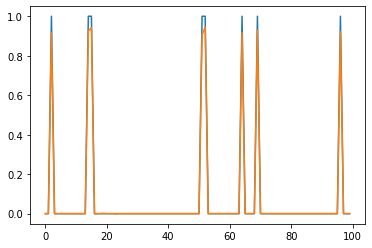

In [21]:
plt.plot(x_true)
plt.plot(w_guess)

In [22]:
w_guess_nonzero = np.nonzero(w_guess)
np.isin(x_true_nonzero, w_guess_nonzero)

array([[ True,  True,  True,  True,  True,  True,  True,  True]])

Clearly, $\verb+w_guess+$ contains nonzero entries in mostly the same places as does $\verb+x_true+$. Next, we look at how many nonzero entries there are in $\verb+w_guess+$.

In [23]:
print("This is the number of nonzero entries in w_guess: " + str(len(w_guess_nonzero[0])))
print("This is the number of nonzero entries in x_true: " + str(len(x_true_nonzero[0])))

This is the number of nonzero entries in w_guess: 11
This is the number of nonzero entries in x_true: 8


Note that, even though there are more nonzero entries in $\verb+w_guess+$ than in $\verb+x_true+$, the number of non-sparse entries is much closer than what was obtained using the standard lasso method, using all the same parameters. Thus, we have a higher level of precision, as we desired.

Last, we look at the number of iterations SR3 took to converge and the number of seconds required fro convergence.

In [24]:
print("This is the number of iterations required for SR3 to converge: " + str(iters_sr3))
print("This is the number of seconds it takes for SR3 to converge: " + str(end_sr3 - start_sr3))

This is the number of iterations required for SR3 to converge: 88
This is the number of seconds it takes for SR3 to converge: 0.00992584228515625


Note that, even for a small-dimension problem, the number of iterations required for SR3 to converge is decreased by an order of 10, as for the number of seconds required for convergence. This is exactly what we anticipated from the results shown in J33.

Use relationship between condition number of $A^{\top}A$ to get $\lambda$ parameter value for relaxed problem. It's how I define it using the variable $\verb+lam_sr3+$.

Next, we seek to deblur an image using SR3, implementing the FISTA algorithm.

## Section 3 - FISTA on non-image data

Before we do image deblurring, we're just going to run FISTA on the contrived data. So we reinitialize everything according to Section (1) again

In [127]:
cond_A = svdvals(A)[0]
eta = 0.001
k = 0
tol = 0.00001
max_step = 100
t = 1
L = np.linalg.eigvals(A.T@A)[0]
Linv = 1/L
assert eta <= 1/(cond_A**2)

In [123]:
def FISTA_norm(x, y, t, max_step, k, lam, tol):
    start = time.time()
    while (max_step > tol):
        k += 1
        x_old = x
        y_old = y
        t_old = t
        z = y_old - Linv*(A.T)@((A@y_old)-b)
        x = prox_op(z, lam*Linv)
        t = (1 + np.sqrt(1 + 4*t_old**2))/2
        y = x + ((t_old-1)/t)*(x - x_old)
        step = abs((y - y_old)*Linv)
        max_step = step.max()
    end = time.time()
    return y, start, end, k

In [128]:
y_fista, start, end, k_fista = FISTA_norm(x_init, x_init, t, max_step, k, lam, tol)

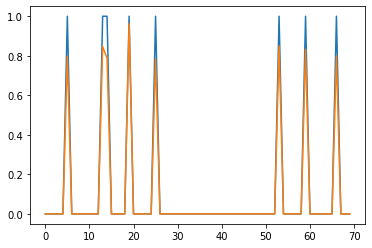

In [129]:
from matplotlib import pyplot as plt
plt.plot(x_true)
plt.plot(y_fista)

The results from the plot are encouraging since they tell us that our vanilla FISTA model running on just the contrived data seems to be working.

In [130]:
y_fista_nonzero = np.nonzero(y_fista)
x_true_nonzero = np.nonzero(x_true)
np.isin(x_true_nonzero, y_fista_nonzero)

array([[ True,  True,  True,  True,  True,  True,  True,  True]])

In [131]:
print("This is the number of nonzero entries in y_fista: " + str(len(y_fista_nonzero[0])))
print("This is the number of nonzero entries in x_true: " + str(len(x_true_nonzero[0])))

This is the number of nonzero entries in y_fista: 8
This is the number of nonzero entries in x_true: 8


In [132]:
print("This is the number of iterations required for FISTA to converge: " + str(k_fista))
print("This is the number of seconds it takes for FISTA to converge: " + str(end - start))

This is the number of iterations required for FISTA to converge: 31
This is the number of seconds it takes for FISTA to converge: 0.002595186233520508


I'm not really going to comment on any of this. Needless to say, FISTA is working about as well as we could hope.

## Section 4 - FISTA on image deblurring

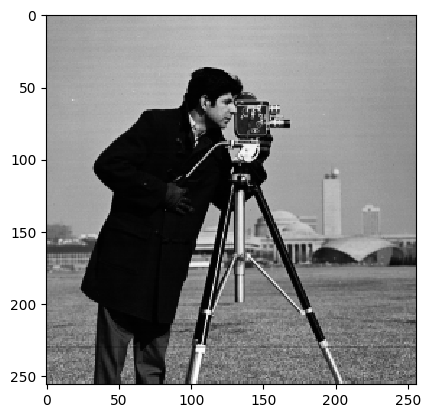

In [6]:
original = plt.imread("cameraman256.png")
plt.imshow(original,interpolation="nearest",cmap=plt.cm.gray)

In [7]:
m=original.shape[0]
n=original.shape[1]

We are now going to blur this image, following the details provided in the FISTA paper. To do this, we pass the image through a Gaussian blur of size $9 \times 9$ and standard deviation 4, which we follow by adding on a zero-mean white Gaussian noise with standard deviation $10^{-3}$.

To pass the image through the Gaussian blur, we first need to import a package from $\verb+scipy+$ and create a function on our own to approximate the $\verb+imfilter+$ and $\verb+fspecial+$ functions in $\verb+MATLAB+$.

Do adjoint test for 2d convolution operation (formula online). Look for code that already implements this.

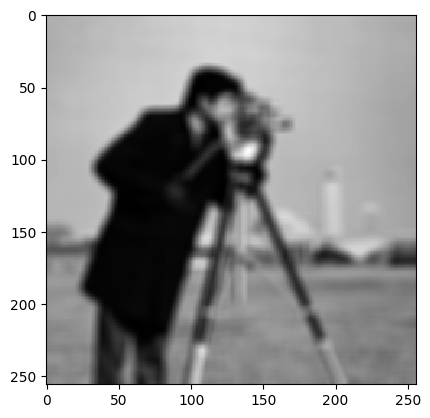

In [8]:
from operators import blur_operator_torch
blurred = blur_operator_torch(original)
plt.imshow(blurred.view(m,m),interpolation="nearest",cmap=plt.cm.gray)

As we can see, this successfully blurred the image as we desired. Now we look to construct the problem by first constructing our blur operator.

Is there a fast way to solve blur transpose blur: $R^\top R$. Yes, think about Woodbury matrix inversion. Look in book for case where A is actually spectrally diagonalizable (through Fourier transform matrices). Derive closed form solution in SR3 (look at pictures)

#### Here, we are going to perform unit, adjoint tests for our main operators: blur, wavelets, and gradient

To do this, we first initialize random torch 1d tensors

In [9]:
rand_1 = torch.rand(m**2)
rand_2 = torch.rand(m**2)

In [10]:
from operator_tests import test_blur
test_blur(rand_1,rand_2,3)

This essentially passes.

Here we now perform the adjoint test for the adjoint of the grad operator, since, if it passes, this will tell us if our operator has been implemented successfully.

Todo for next week:
1. Fix grad function so it passes the unit test. It should be passing.
2. Find information on conjugate gradient method and conjugate gradient differentiation through torch. For SR3, we need to be running about 20 steps of CG to find inverse of $H_{\kappa}$, where we have
\begin{align*}
    H_\kappa x = A^{\top}Ax + \kappa x
\end{align*}
Where does the differentiation come in? Sasha wanted me to do this on torch because everything else has been running on torch. I assume after I've finished knowing how the gradient works. Also, where does the gradient come in? Because it seems that there isn't really a gradient being calculated or found.
3. Fix wavelet operators to be inside prox function. That's easy to do.
4. Do Woodbury matrix identity proof.
5. Work on NSF and DOE applications.

To do CG in torch, look at this link: https://github.com/sbarratt/torch_cg

In [11]:
def gen_function(x,b):
    Ax = blur_operator_torch(x)
    w = Ax - b
    return (torch.linalg.norm(w)**2)

In [12]:
from operator_tests import test_grad
test_grad(rand_1,rand_2,gen_function,3)

Here, we now perform the adjoint test for the adjoint of the wavelet operator, as we must check to see if our operator is being implemented correctly.

In [13]:
from operator_tests import test_wavelet
test_wavelet(rand_2)

Here we take the discrete 2D cosine transform of the matrix $A^\top A$. Once we do this, we can use the formula
\begin{align*}
    \lambda_{i} = \frac{[Ca_1]_{i}}{c_{i1}}
\end{align*}
where $a_1$ is the first column of $A^\top A$ and $C$ is the resulting matrix from the discrete cosine transform. I get this information from the book Deblurring Images.

In [72]:
from operators import evals_blur, fspecial
L = evals_blur(ret_torch=False)[0]*2
Linv = 1/L
k_PG = 0
k_FISTA = 0
max_iter = 200

Now we are going to define our first guesses and reshape all of our data.

In [15]:
b = blurred
x_init = torch.ones(m**2)
y0 = x_init.clone()
t = 1
lam = 2e-5

Since we also need the gradient of
\begin{align*}
    f(x) = ||Ax-b||^{2}
\end{align*}
which is
\begin{align*}
    \nabla f(x) = 2A^{\top}(Ax-b)
\end{align*}
we define a quick anonymous function to do the calculations for us

In [69]:
from operators import wavelet_op1d_torch, wavelet_inverse_torch
def prox_op_torch_l1(x,lambd):
    c = wavelet_op1d_torch(x)
    d = torch.sign(c[0]) * torch.relu(torch.abs(c[0]) - lambd)
    e = wavelet_inverse_torch(d,c[1])
    return e

def gen_function(x,b):
    Ax = blur_operator_torch(x)
    w = Ax - b
    return (torch.linalg.norm(w)**2)

def g(lam,x):
    return lam*torch.linalg.norm(wavelet_op1d_torch(x)[0], ord=1)

In [17]:
from optimization_algs import FISTA
y_PG, start_PG, end_PG, step_sizes_PG, function_values_PG = FISTA(x_init, y0, b, t, k_PG, max_iter, lam, Linv, prox_op_torch_l1, gen_function,g,False)

In [18]:
y, start, end, step_sizes, function_values = FISTA(x_init, y0, b, t, k_FISTA, max_iter, lam, Linv, prox_op_torch_l1, gen_function,g,True)

List:
1. Operators - Figure out how to get adjoint codes for operators work -> make adjoint test a unit test. DONE
2. Abstract the algorithms to take prox's and grad's, and then build the pieces to fit into equation. DONE
3. Include unit tests for gradient and prox. DONE
4. Store information for both PG and FISTA on function value and step size (defined above) DONE
5. Run prox gradient on deblurring problem. DONE
6. Do SR3 and in so doing make everything agnostic inside the optimzation algorithms NOT DONE
7. Also come up with just PG and no FISTA and then compare, so come up with "if accelerate option" DONE

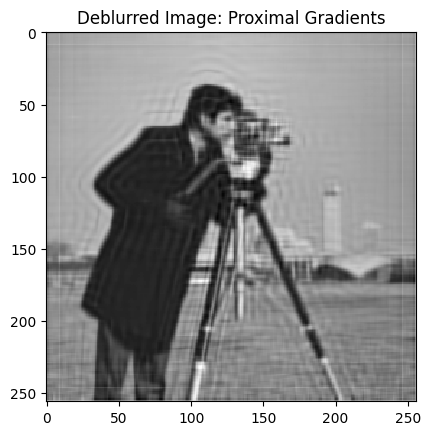

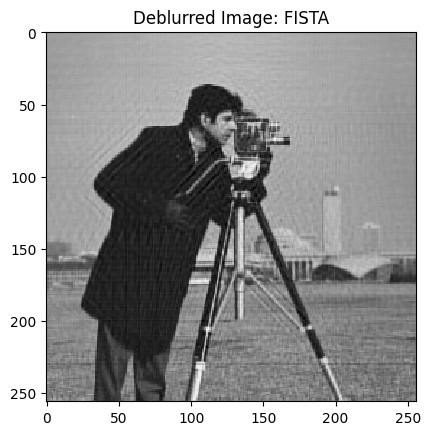

In [19]:
from plotting import FISTA_plot
FISTA_plot(y_PG,m,"Deblurred Image: Proximal Gradients")
plt.show()
FISTA_plot(y,m,"Deblurred Image: FISTA")

The number of iterations is the same between both of these methods, but, as we can tell, and as we would hypothesize by using the FISTA acceleration step, it seems that the FISTA algorithm is converging faster.

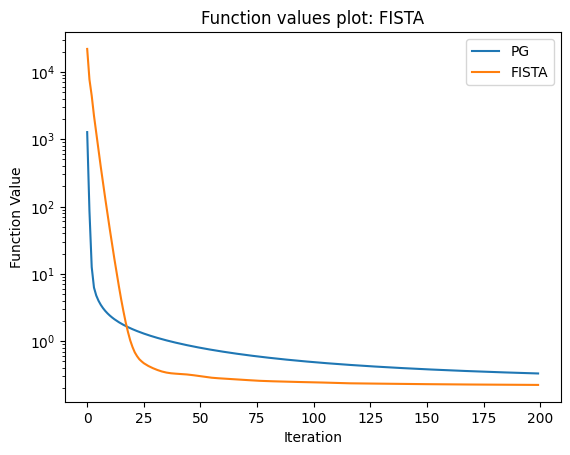

In [20]:
from plotting import function_vals_plot
function_vals_plot(max_iter, function_values_PG, "PG")
function_vals_plot(max_iter, function_values, "FISTA")

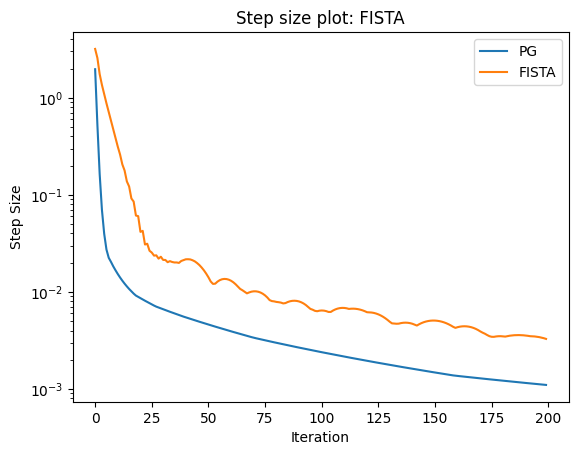

In [21]:
from plotting import step_size_plot
step_size_plot(max_iter, step_sizes_PG, "PG")
step_size_plot(max_iter, step_sizes, "FISTA")

In [22]:
print("The step size at iteration 1 is " + str(step_sizes[0]))
print("The step size at iteration 100 is " + str(step_sizes[99]))
print("The step size at iteration 200 is " + str(step_sizes[199]))

The step size at iteration 1 is tensor(3.1828)
The step size at iteration 100 is tensor(0.0064)
The step size at iteration 200 is tensor(0.0033)


## Section 5 - SR3 with FISTA for image deblurring

In [21]:
from operators import evals_blur, fspecial, blur_adjoint_torch
L = evals_blur(ret_torch=False)[0]*2
Linv = 1/L # Way pessimistic. Implement the smoothness condition that is in Alex Hsu's notes.
k_SR3 = 0
max_iter = 200
# max_iter = 1200
kappa = 1 #was 1
lam_sr3 = 2e-5
# lam_sr3 *= Linv

b = blurred.clone()
x_init = torch.ones(m**2)
y0 = x_init.clone()
t = 1
eta = 1 / kappa # get rid of either kappa or eta. 

In [22]:
def sr3_function(x,w,b,eta):
    Ax = blur_operator_torch(x)
    y = Ax - b
    y = 0.5*(torch.linalg.norm(y)**2)

    z = (0.5/eta)*(torch.linalg.norm(x-w)**2)

    # g = (1/eta)*(w - x)
    return y + z

In [23]:
from torch_dct import dct_2d,idct_2d, dct, idct

In [24]:
import torch
import torch.fft
def blur_matrix(m=256,n=256,shape=(9,9),blursigma=4.0):
    # Parameters of blurring kernel
    nblur = shape[0]  # Gives size of filter (two standard deviations here)

    # Set up Gaussian blurring
    inds = torch.arange(-nblur, nblur + 1)
    blurmat1 = inds ** 2 + inds.unsqueeze(1) ** 2
    blurmat1 = torch.exp(-0.5 * blurmat1 / blursigma ** 2)
    bscale = blurmat1.abs().sum()
    blurmat1 = blurmat1 / bscale
    blurmat = torch.zeros(m, n)
    blurmat[0:2 * nblur + 1, 0:2 * nblur + 1] = blurmat1
    blurmat = torch.roll(blurmat, shifts=(-nblur, -nblur), dims=(0, 1))
    blurhat = torch.fft.fftn(blurmat)
    S1 = torch.linalg.eigvals(blurmat)
    # _, S, _ = torch.linalg.svd(blurmat)
    S1 = torch.real(S1)
    return S1, S, blurmat

In [25]:
S = evals_blur(shape=(int(np.sqrt(m)),int(np.sqrt(m))),ret_torch=True)[1]*2

In [33]:
A = torch.zeros(m,m)
h = fspecial((9,9),4.0,True)
padding = nn.ReflectionPad2d(4)
for i in range(m):
    for j in range(n):
        original_pixel = torch.zeros_like(torch.from_numpy(original))
        original_pixel[i,j] = 1
        original_pixel = original_pixel.unsqueeze(0).unsqueeze(0)
        original_pixel = padding(original_pixel)
        blurred_pixel = F.conv2d(original_pixel,h.unsqueeze(0).unsqueeze(0))
        A[i*n+j,:] = blurred_pixel.flatten()

RuntimeError: The expanded size of the tensor (256) must match the existing size (16) at non-singleton dimension 0.  Target sizes: [256].  Tensor sizes: [16]

In [27]:
def FISTA_SR3(w,v,b,t,k,max_iter,eta,prox,lam,m,sr3_function,it_num=20,accelerate=True,reflexive=True):
    """
    Implenting SR3 with Fista acceleration just as in J33 paper. No TV regularization,
    we regularize with 1-norm with C = I.
    """
    start = time.time()
    step_size_list = []
    function_values = []
    atb = blur_adjoint_torch(b)
    x_init = torch.zeros(m**2)
    if reflexive:
        # S = blur_matrix(m,m)[1]
        S = evals_blur(shape=(int(np.sqrt(m)),int(np.sqrt(m))),ret_torch=True)[1]*2
        S = S.flatten(start_dim=0,end_dim=1)
        S = S**2
        S = S + eta
        D = 1/S
        D = torch.diag(D)

        def H_kappa(eta, D_inv, x):
            """
            The H_k matrix operation defined in J33, simplified by reflexive
            and/or periodic boundary conditions.
            """
            if len(x.size()) == 1:
                x = torch.reshape(x, (m,m))
            return idct_2d(torch.matmul(D_inv,dct_2d(x)))

    if reflexive == False:
        def H_kappa(kap, x):
            """
            The H_k matrix operation defined in J33 in the context of image deblurring
            with blur and blur_adjoint operations defined for PyTorch tensors.
            """
            return blur_adjoint_torch(blur_operator_torch(x)) + kap*x

    while (k <= max_iter):
        k += 1
        v_old = v
        w_old = w
        t_old = t
        z = atb + (1/eta)*w_old
        if reflexive:
            x = H_kappa(eta,D,z)
            x = x.flatten(start_dim=0, end_dim=1)
        if reflexive == False:
            x = conjgrad(H_kappa,z,x_init,it_num,(1/eta))
        v = prox(x,eta*lam)
        if accelerate:
            t = 0.5*(1 + np.sqrt(1 + 4*(t_old**2)))
            w = v + (t_old/t)*(v - v_old)
        else:
            w = v
        step = abs((w-w_old)*(1/eta))
        max_step = torch.max(step)
        function_values.append(sr3_function(x,w,b,eta))
        step_size_list.append(max_step)
    end = time.time()

    return x,w, start, end, step_size_list, function_values

Analytic expression for $H_\kappa^{-1}$
\begin{align*}
    H_\kappa^{-1} = (\frac{1}{\eta}I + C^{\top}\Lambda^{2}C)^{-1}
\end{align*}
We then
\begin{align*}
    x = C^{\top}[\Lambda^2 + \frac{1}{\eta}I]^{-1}Cy
\end{align*}

In [28]:
# from optimization_algs import FISTA_SR3
from optimization_algs import conjgrad
x,w, start_SR3, end_SR3, step_list_SR3, function_values_SR3 = FISTA_SR3(w=x_init,v=y0,b=b,t=t,k=k_SR3 \
    , max_iter=max_iter, eta=eta, prox=prox_op_torch_l1,lam=lam_sr3,m=m,sr3_function=sr3_function,reflexive=True,it_num=50)

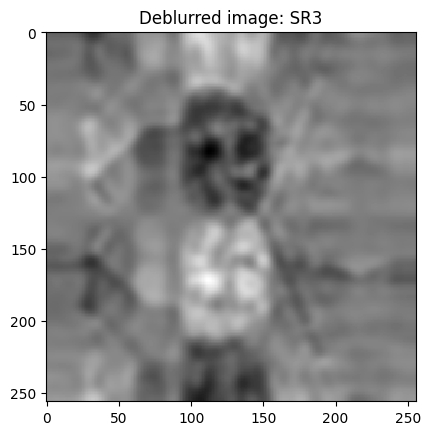

In [29]:
FISTA_plot(w,m,"Deblurred image: SR3")

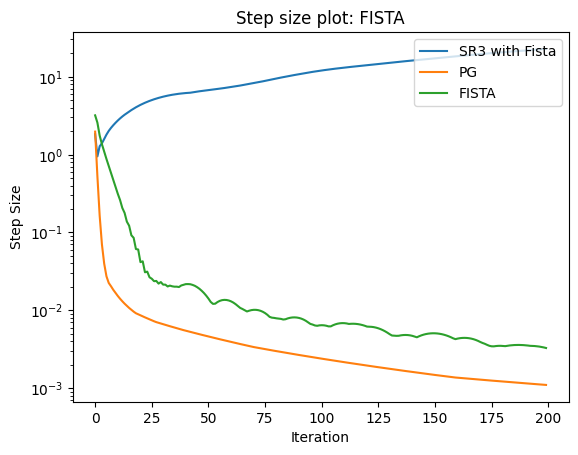

In [30]:
from plotting import step_size_plot
step_size_plot(max_iter,step_list_SR3,"SR3 with Fista")
step_size_plot(max_iter, step_sizes_PG, "PG")
step_size_plot(max_iter, step_sizes, "FISTA")

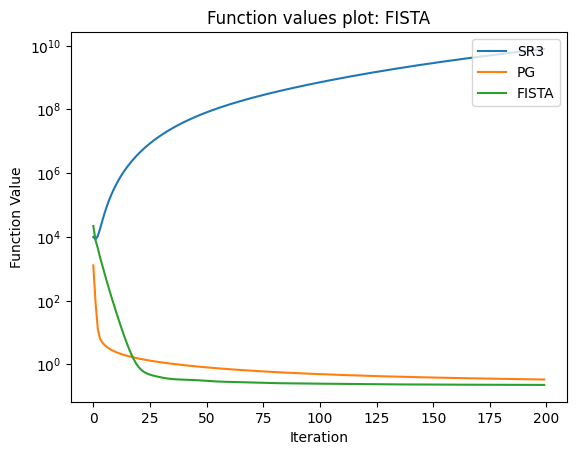

In [31]:
from plotting import function_vals_plot
function_vals_plot(max_iter,function_values_SR3,"SR3")
function_vals_plot(max_iter, function_values_PG, "PG")
function_vals_plot(max_iter, function_values, "FISTA")

SR3FISTA beats just normal FISTA in terms of SSIM, where SSIM is defined mathematically by
\begin{align*}
    \mathrm{SSIM}(x,y) = \frac{(2\mu_{x}\mu_{y} + c_1)(2\sigma_{xy} + c_2)}{(\mu_{x}^{2} + \mu_{y}^{2} + c_{1})(\sigma_{x}^{2} + \sigma_{y}^{2} + c_{2})}
\end{align*}

In [450]:
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM

In [451]:
ssim = SSIM(data_range=1.0)

In [452]:
print("This is the SSIM of SR3FISTA: " + str(ssim(w.view(m,m).unsqueeze(0).unsqueeze(0),torch.from_numpy(original).unsqueeze(0).unsqueeze(0))))

This is the SSIM of SR3FISTA: tensor(0.8453)


In [453]:
print("This is the SSIM of just FISTA: " + str(ssim(y.view(m,m).unsqueeze(0).unsqueeze(0),torch.from_numpy(original).unsqueeze(0).unsqueeze(0))))

This is the SSIM of just FISTA: tensor(0.8332)


Create simulated dataset that doesn't go too far back to the data-generating mechanism. Run BoP on this simulated data.

## Section 6 - Image denoising (salt and pepper)

In [23]:
from skimage.util import random_noise

In [121]:
def salt_paper_noise(img):
    # salt_img = torch.tensor(random_noise(img, mode='salt', amount=0.05))
    if len(img.size()) == 1:
        m = int(np.sqrt(img.size(0)))
        img = torch.reshape(img, (m,m))
    salt_img = img + ((0.01**0.5)*torch.randn(256,256))
    return salt_img

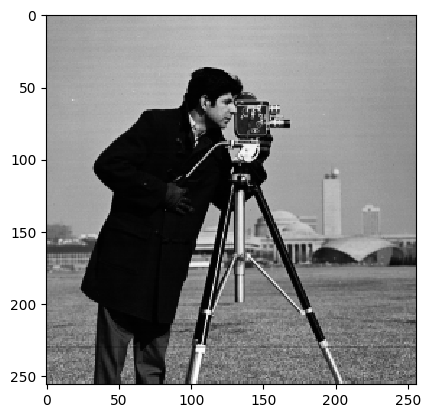

In [122]:
org_to_denoise_tensor = torch.from_numpy(original)
plt.imshow(org_to_denoise_tensor,interpolation="nearest",cmap=plt.cm.gray)

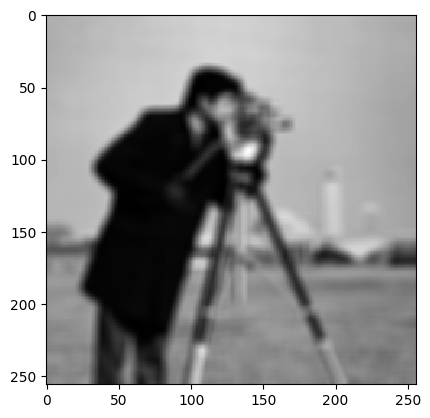

In [138]:
salt_img_1 = blur_operator_torch(org_to_denoise_tensor)
# salt_img_1 = salt_paper_noise(salt_img_1)
# salt_img = salt_img_1.flatten(start_dim=0, end_dim=1)
plt.imshow(salt_img_1.view(m,m),interpolation="nearest",cmap=plt.cm.gray)

In [139]:
from operators import evals_blur, fspecial
L = evals_blur(ret_torch=False)[0]*2
Linv = 1/L
k_PG = 0
k_FISTA = 0
max_iter = 200
x_init = torch.ones(m**2)
y0 = x_init.clone()
t = 1
lam = 2e-5

In [140]:
def prox_op_torch_l1(x,lambd):
    c = wavelet_op1d_torch(x)
    d = torch.sign(c[0]) * torch.relu(torch.abs(c[0]) - lambd)
    e = wavelet_inverse_torch(d,c[1])
    return e

def gen_function(x,b):
    Ax = blur_operator_torch(x)
    w = Ax - b
    return (torch.linalg.norm(w)**2)

def g(lam,x):
    return lam*torch.linalg.norm(wavelet_op1d_torch(x)[0], ord=1)

In [143]:
y_sp, start, end, step_sizes, function_values = FISTA(x_init, y0, salt_img_1, t, k_FISTA, max_iter, lam, Linv, prox_op_torch_l1, gen_function,g,True)

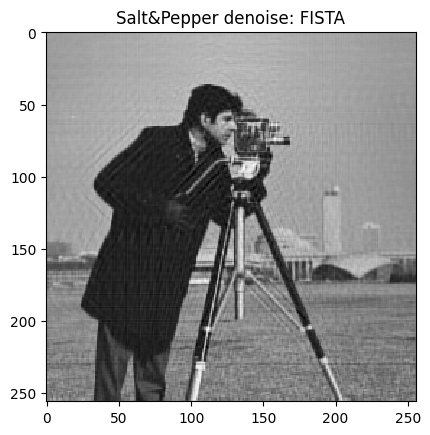

In [144]:
FISTA_plot(y_sp,m,"Salt&Pepper denoise: FISTA")